# Bidirectional Quadratic Voting

## Experiments

### Simulator

In [68]:
import numpy as np
from scipy import stats

def generate_candidate_preferences(num_candidates, num_issues, ideology_range):
    candidate_preferences = np.zeros((num_candidates, num_issues))
    for i, ideology in enumerate(ideology_range):
        # Environmental Protection: Higher for left-wing, lower for right-wing
        candidate_preferences[i, 0] = np.clip(5 - ideology * 2 + np.random.normal(0, 0.3), 0, 5)

        # Economic Growth: Higher for right-wing, lower for left-wing
        candidate_preferences[i, 1] = np.clip(2.5 + ideology * 2 + np.random.normal(0, 0.3), 0, 5)

        # Education Reform: Less biased by ideology
        candidate_preferences[i, 2] = np.clip(3 + ideology * 0.5 + np.random.normal(0, 0.5), 0, 5)

        # Social Security: Higher for left-wing, lower for right-wing
        candidate_preferences[i, 3] = np.clip(4 - ideology * 1.5 + np.random.normal(0, 0.3), 0, 5)

        # Foreign Policy: Slightly higher for right-wing
        candidate_preferences[i, 4] = np.clip(3 + ideology + np.random.normal(0, 0.3), 0, 5)

        # Political Performance: Set specified values
        candidate_preferences[i, 5] = [3.5, 0.5, 2.5, 4.5, 1.5][i]

        # Technology: Only Candidate 2 has high expertise
        candidate_preferences[i, 6] = 4.5 if i == 1 else np.clip(1.5 + np.random.normal(0, 0.3), 0, 5)

    return candidate_preferences

def generate_voter_preferences(num_voters, num_issues, ideology_distribution):
    # Generate ideology distribution
    if ideology_distribution == 'normal':
        voter_ideologies = np.random.normal(0, 0.5, num_voters)
    elif ideology_distribution == 'bimodal':
        voter_ideologies = np.concatenate([np.random.normal(-0.5, 0.3, num_voters//2), np.random.normal(0.5, 0.3, num_voters//2)])
    elif ideology_distribution == 'skewed_left':
        voter_ideologies = np.random.beta(2, 5, num_voters) * 2 - 1
    elif ideology_distribution == 'skewed_right':
        voter_ideologies = np.random.beta(5, 2, num_voters) * 2 - 1
    else:
        raise ValueError("Invalid ideology distribution specified")

    voter_preferences = np.zeros((num_voters, num_issues))
    for i, ideology in enumerate(voter_ideologies):
        # Generate basic preferences
        base_preferences = np.array([
            5 - ideology * 2,  # Environmental Protection
            2.5 + ideology * 2,  # Economic Growth
            3 + ideology * 0.5,  # Education Reform
            4 - ideology * 1.5,  # Social Security
            3 + ideology,  # Foreign Policy
            np.random.uniform(0, 5),  # Political Performance
            1.5 + np.random.normal(0, 0.3)  # Technology (generally low)
        ])

        # Add personal variation
        personal_variation = np.random.normal(0, 0.5, num_issues)

        # Simulate social influence (from people with similar ideologies)
        social_influence = np.mean([np.random.normal(0, 0.3, num_issues) for _ in range(5)], axis=0)

        # Calculate final preferences
        voter_preferences[i] = np.clip(base_preferences + personal_variation + social_influence, 0, 5)

    # Make 50% of voters prioritize political performance
    performance_voters = np.random.choice(num_voters, int(num_voters * 0.5), replace=False)
    voter_preferences[performance_voters, 5] = np.random.uniform(4.0, 5.0, len(performance_voters))

    # Make 5% of voters prioritize technology
    tech_voters = np.random.choice(num_voters, num_voters // 20, replace=False)
    voter_preferences[tech_voters, 6] = np.random.uniform(4.0, 5.0, len(tech_voters))

    return voter_preferences, voter_ideologies

def quadratic_voting(preferences, credits):
    # Normalize preferences to a range of 0 to 1
    normalized_prefs = (preferences - np.min(preferences)) / (np.max(preferences) - np.min(preferences))

    # Calculate votes for each preference (based on quadratic function)
    votes = np.sign(normalized_prefs) * np.sqrt(np.abs(normalized_prefs))

    # Scale votes so that the total cost equals the specified credits
    total_cost = np.sum(votes**2)
    if total_cost > 0:
        scale_factor = np.sqrt(credits / total_cost)
        votes = votes * scale_factor

    return votes

def calculate_normal_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        # Calculate similarity with each candidate using cosine similarity
        similarities = [cosine_similarity(voter, candidate) for candidate in candidate_preferences]
        # Add score to the candidate with the highest similarity
        matching_scores[np.argmax(similarities)] += 1
    # Normalize scores
    return matching_scores / np.sum(matching_scores)

def calculate_quadratic_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        voter_votes = quadratic_voting(voter, 100)
        candidate_scores = [cosine_similarity(voter_votes, candidate) for candidate in candidate_preferences]
        normalized_scores = (candidate_scores - np.min(candidate_scores)) / (np.max(candidate_scores) - np.min(candidate_scores))
        matching_scores += normalized_scores
    return matching_scores / np.sum(matching_scores)

def calculate_bidirectional_quadratic_voting_matching_scores(voter_preferences, candidate_preferences):
    matching_scores = np.zeros(len(candidate_preferences))
    for voter in voter_preferences:
        voter_votes = quadratic_voting(voter, 100)
        candidate_votes = [quadratic_voting(candidate, 100) for candidate in candidate_preferences]
        candidate_scores = [cosine_similarity(voter_votes, c_votes) for c_votes in candidate_votes]
        normalized_scores = (candidate_scores - np.min(candidate_scores)) / (np.max(candidate_scores) - np.min(candidate_scores))
        matching_scores += normalized_scores
    return matching_scores / np.sum(matching_scores)

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

### Prerequisites

In [69]:
import numpy as np

np.random.seed(42)

# Setting up issues
# Setting up issues
issues = ['Environmental Protection', 'Economic Growth', 'Education Reform', 'Social Security', 'Foreign Policy', 'Political Performance', 'Technology']
num_issues = len(issues)

# Setting up candidates
num_candidates = 5
candidates = [f'Candidate{i+1}' for i in range(num_candidates)]

# Setting up number of voters
num_voters = 10000

# Setting up ideology axis (-1: Far Left, 0: Center, 1: Far Right)
ideology_range = np.linspace(-1, 1, num_candidates)

# Generate candidate preferences (fixed)
candidate_preferences = generate_candidate_preferences(num_candidates, num_issues, ideology_range)

# Voter distribution patterns
voter_distributions = ['normal', 'bimodal', 'skewed_left', 'skewed_right']

### Simulation

#### Candidate Preferences

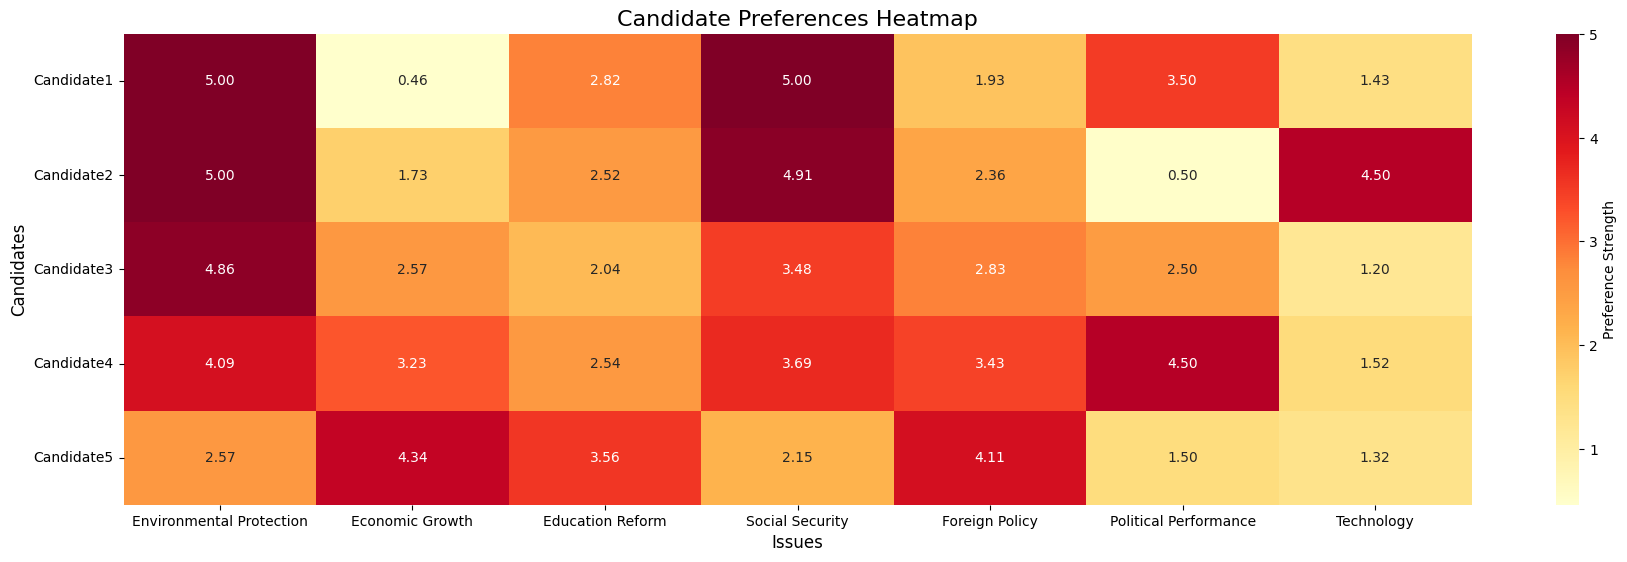

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# データの準備
issues = ['Environmental Protection', 'Economic Growth', 'Education Reform', 'Social Security', 'Foreign Policy', 'Political Performance', 'Technology']
candidates = ['Candidate1', 'Candidate2', 'Candidate3', 'Candidate4', 'Candidate5']
ideology_range = [-1.00, -0.50, 0.00, 0.50, 1.00]

data = np.array([
    [5.00, 0.46, 2.82, 5.00, 1.93, 3.50, 1.43],
    [5.00, 1.73, 2.52, 4.91, 2.36, 0.50, 4.50],
    [4.86, 2.57, 2.04, 3.48, 2.83, 2.50, 1.20],
    [4.09, 3.23, 2.54, 3.69, 3.43, 4.50, 1.52],
    [2.57, 4.34, 3.56, 2.15, 4.11, 1.50, 1.32]
])

# ヒートマップの作成
plt.figure(figsize=(20, 6))
ax = sns.heatmap(data, annot=True, cmap="YlOrRd", fmt=".2f",
                 xticklabels=issues, yticklabels=candidates,
                 cbar_kws={'label': 'Preference Strength'})

plt.title("Candidate Preferences Heatmap", fontsize=16)
plt.xlabel("Issues", fontsize=12)
plt.ylabel("Candidates", fontsize=12)

# 横軸のラベルを水平に配置
plt.xticks(rotation=0, ha='center')

# 縦軸のラベルを横向きに配置
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, ha='right')

# レイアウトの調整
plt.tight_layout()

# x軸のラベルの位置を調整
plt.subplots_adjust(bottom=0.15, left=0.15)

plt.show()

#### Voters Distribution

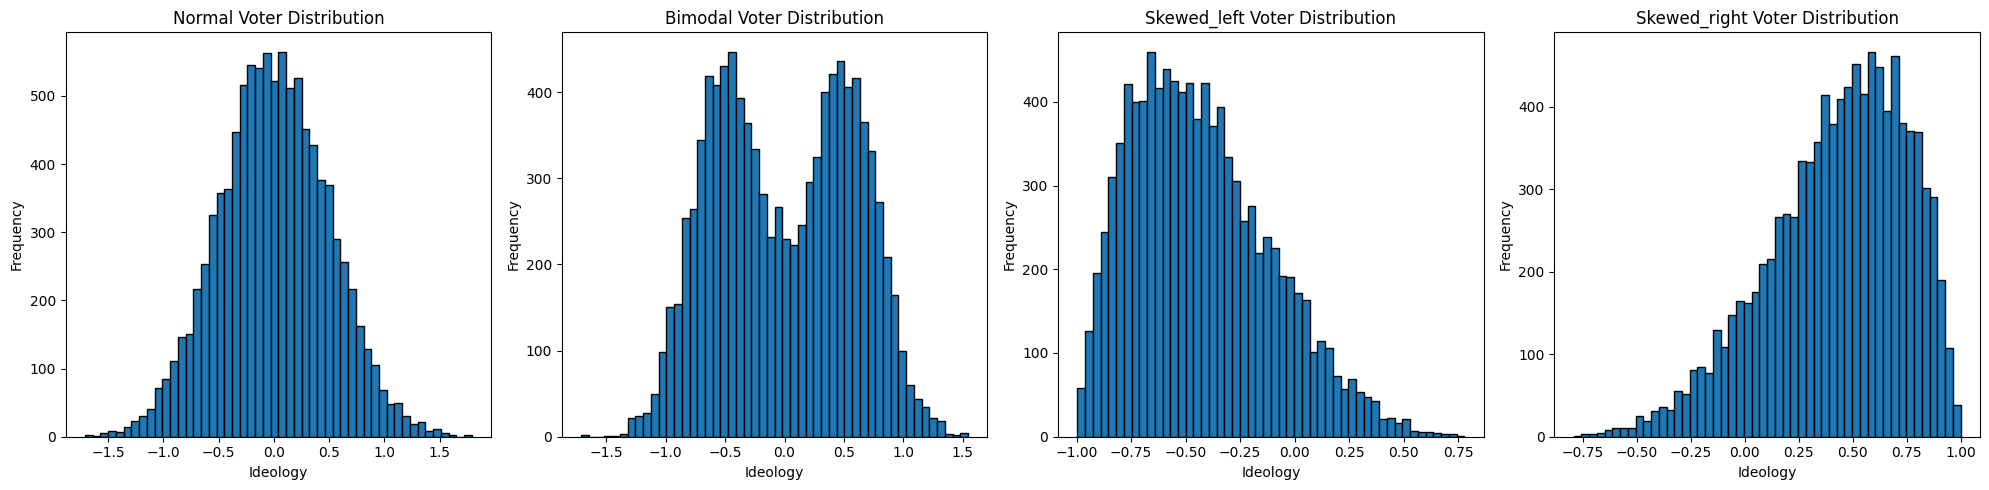

In [73]:
# セル1: 投票者の分布

import matplotlib.pyplot as plt

results = {}
for v_dist in voter_distributions:
    voter_preferences, voter_ideologies = generate_voter_preferences(num_voters, num_issues, v_dist)
    normal_scores = calculate_normal_voting_matching_scores(voter_preferences, candidate_preferences)
    quadratic_scores = calculate_quadratic_voting_matching_scores(voter_preferences, candidate_preferences)
    bidirectional_scores = calculate_bidirectional_quadratic_voting_matching_scores(voter_preferences, candidate_preferences)
    results[v_dist] = (voter_ideologies, normal_scores, quadratic_scores, bidirectional_scores)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, (v_dist, (voter_ideologies, _, _, _)) in enumerate(results.items()):
    axes[i].hist(voter_ideologies, bins=50, edgecolor='black')
    axes[i].set_title(f'{v_dist.capitalize()} Voter Distribution')
    axes[i].set_xlabel('Ideology')
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Voting Results

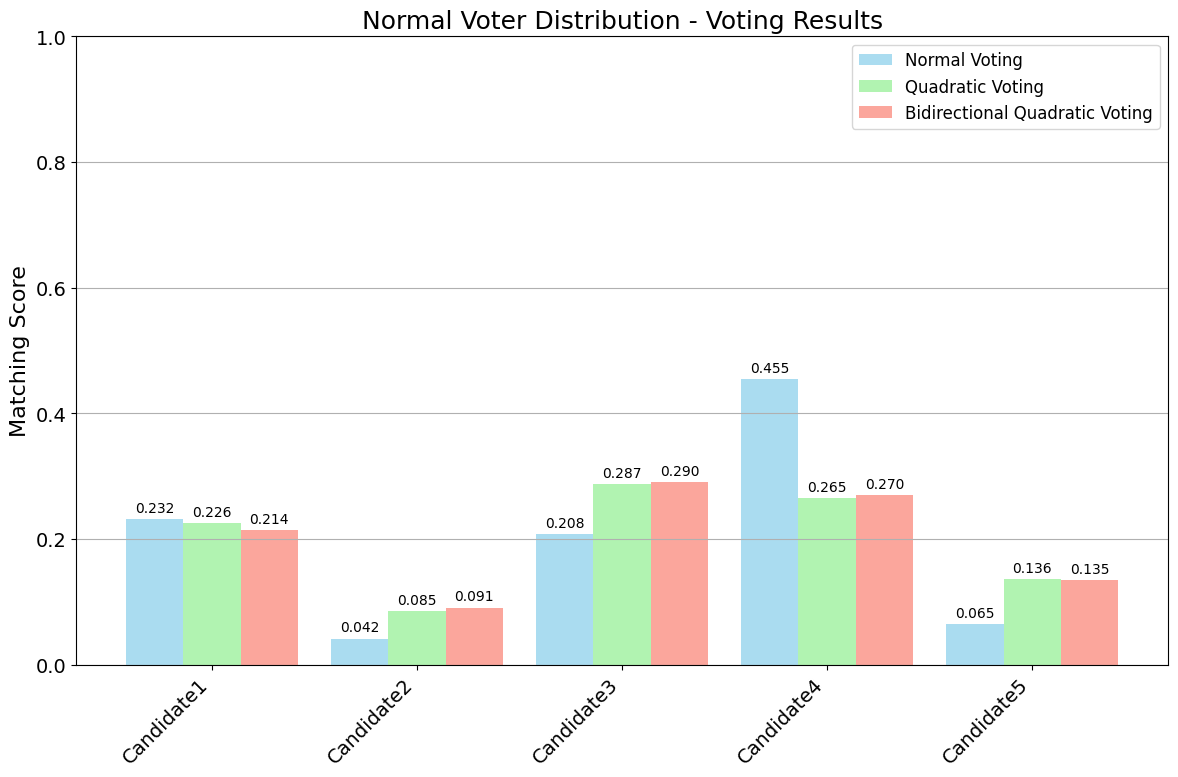

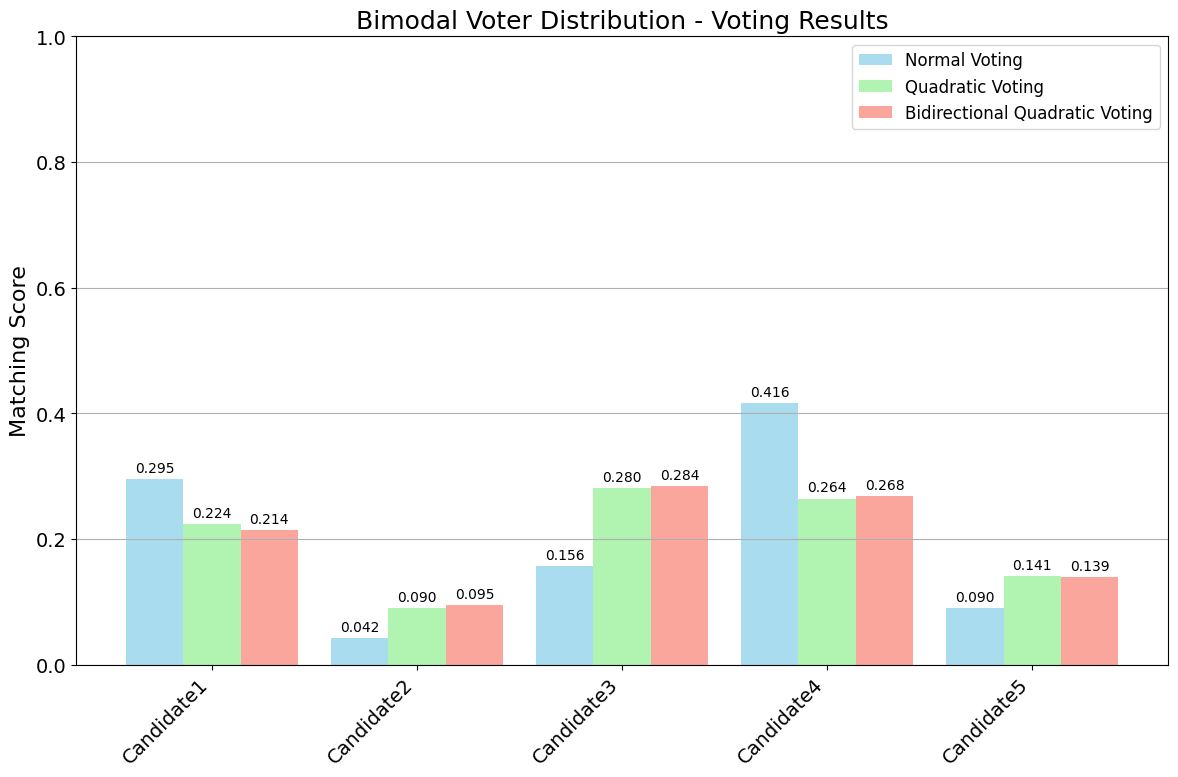

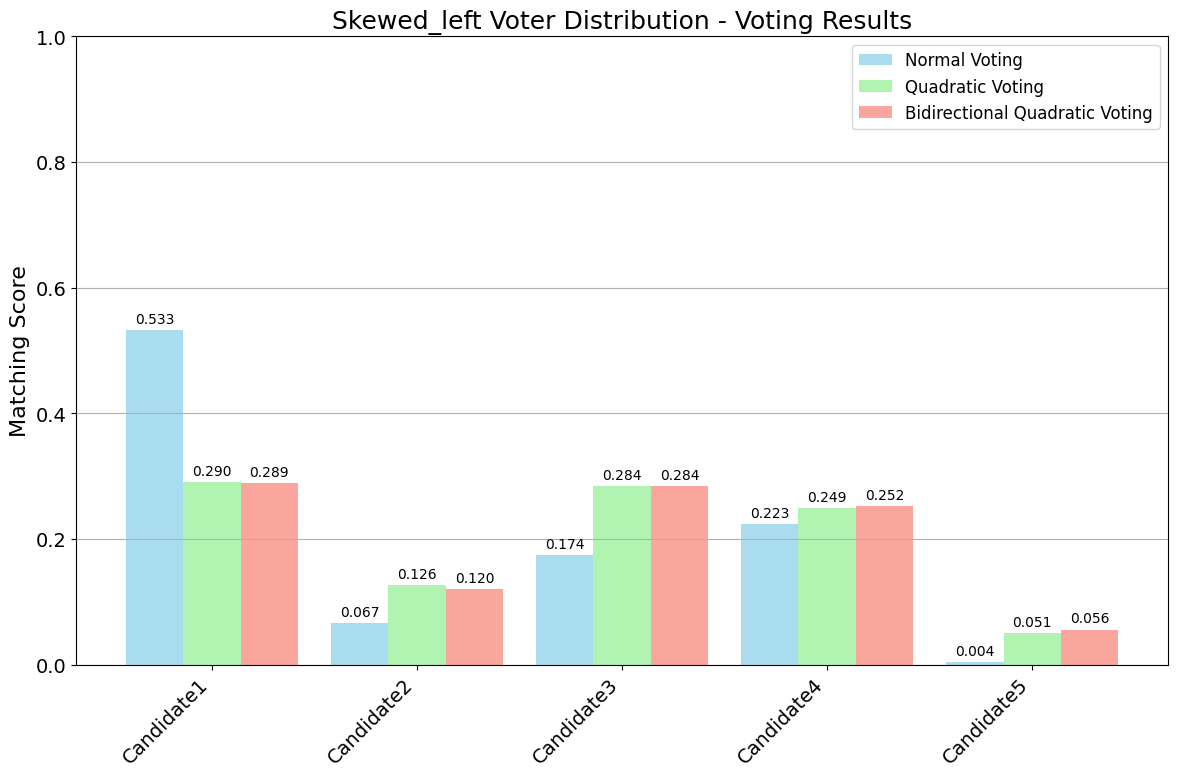

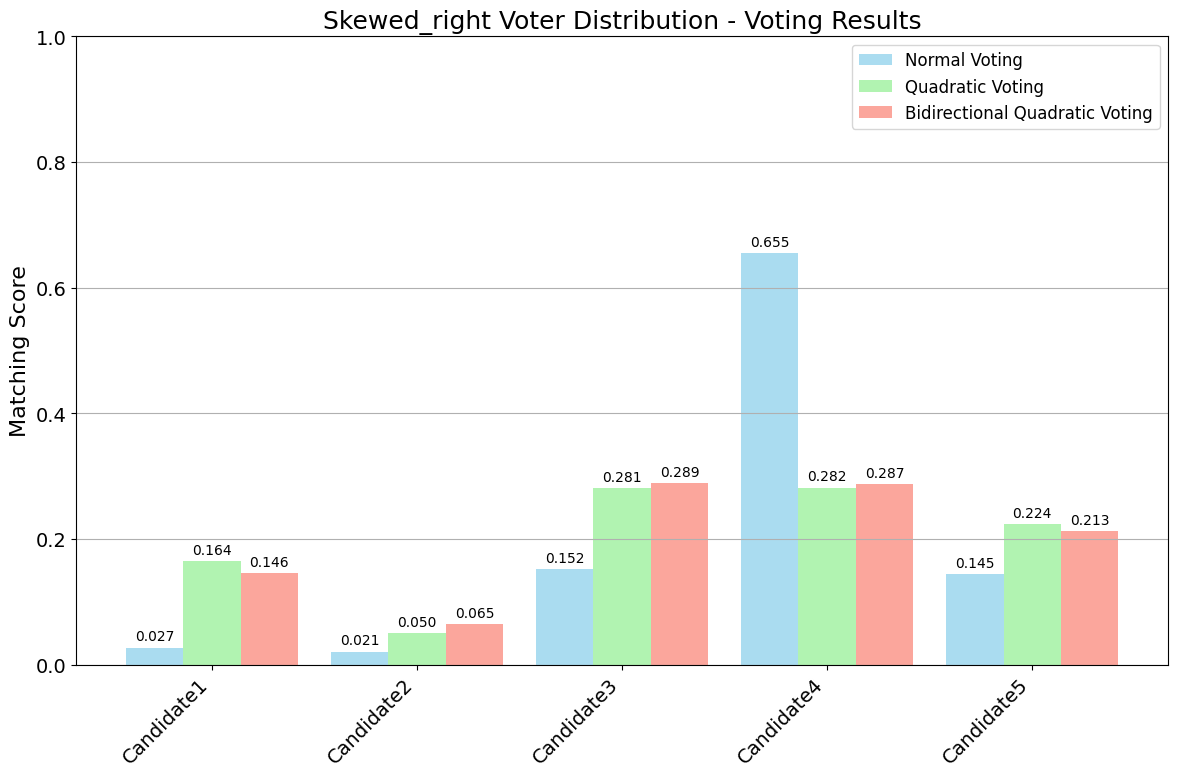

In [82]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})  # 基本のフォントサイズを14に設定

for v_dist, (_, normal_scores, quadratic_scores, bidirectional_scores) in results.items():
    fig, ax_match = plt.subplots(figsize=(12, 8))
    x = np.arange(len(candidates))
    width = 0.28

    rects1 = ax_match.bar(x - width, normal_scores, width, label='Normal Voting', color='skyblue', alpha=0.7)
    rects2 = ax_match.bar(x, quadratic_scores, width, label='Quadratic Voting', color='lightgreen', alpha=0.7)
    rects3 = ax_match.bar(x + width, bidirectional_scores, width, label='Bidirectional Quadratic Voting', color='salmon', alpha=0.7)

    ax_match.set_ylabel('Matching Score', fontsize=16)
    ax_match.set_title(f'{v_dist.capitalize()} Voter Distribution - Voting Results', fontsize=18)
    ax_match.set_xticks(x)
    ax_match.set_xticklabels(candidates, rotation=45, ha='right', fontsize=14)
    ax_match.set_ylim(0, 1)
    ax_match.legend(fontsize=12)
    ax_match.grid(axis='y')

    def autolabel(rects, scores):
        for rect, score in zip(rects, scores):
            height = rect.get_height()
            ax_match.annotate(f'{score:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10)

    autolabel(rects1, normal_scores)
    autolabel(rects2, quadratic_scores)
    autolabel(rects3, bidirectional_scores)

    plt.tight_layout()
    plt.show()